In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from extreme_classification.extreme_dataset import BivariateLogisticDataset
from extreme_classification.extreme_classifier import ExtremeClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [14]:
train_dataset = BivariateLogisticDataset(
    sizes=[5000, 5000],
    alphas=[0.1, 0.5],
    labels=[0, 1],
)

test_dataset = BivariateLogisticDataset(
    sizes=[50000, 50000],
    alphas=[0.1, 0.5],
    labels=[0, 1],
)

# train_dataset = BivariateLogisticDataset(
#     sizes=[250000, 250000],
#     alphas=[0.1, 0.5],
#     labels=[0, 1],
#     ranktransform=True
# )

# test_dataset = BivariateLogisticDataset(
#     sizes=[1000000, 1000000],
#     alphas=[0.1, 0.5],
#     labels=[0, 1],
#     ranktransform=True
# )

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

In [16]:
train_dataset.dataframe = train_dataset.dataframe.sort_values(by="norm", ascending=False)
train_dataset.dataframe["x1"] = train_dataset.dataframe.iloc[:, 0]
train_dataset.dataframe["x2"] = train_dataset.dataframe.iloc[:, 1]
train_dataset.dataframe['r'] = np.sqrt(train_dataset.dataframe['x1']**2 + train_dataset.dataframe['x2']**2)
train_dataset.dataframe['theta'] = np.arctan2(train_dataset.dataframe['x2'], train_dataset.dataframe['x1'])
train_dataset.dataframe.drop(columns=[0, 1], inplace=True)

train_dataset.dataframe

,labels,norm,x1,x2,r,theta
7463,1.0,8334.166667,5000.500000,3333.666667,6009.853051,0.588003
3307,0.0,8334.166667,3333.666667,5000.500000,6009.853051,0.982794
799,0.0,5000.500000,2500.250000,2500.250000,3535.887459,0.785398
1101,0.0,4000.400000,2000.200000,2000.200000,2828.709967,0.785398
2025,0.0,2916.958333,1250.125000,1666.833333,2083.541667,0.927295
...,...,...,...,...,...,...
7774,1.0,2.002302,1.001101,1.001201,1.415842,0.785448
1270,0.0,2.001101,1.000400,1.000700,1.414992,0.785548
1568,0.0,2.000800,1.000600,1.000200,1.414780,0.785198
361,0.0,2.000500,1.000100,1.000400,1.414567,0.785548


In [17]:
test_dataset.dataframe = test_dataset.dataframe.sort_values(by="norm", ascending=False)
test_dataset.dataframe["x1"] = test_dataset.dataframe.iloc[:, 0]
test_dataset.dataframe["x2"] = test_dataset.dataframe.iloc[:, 1]
test_dataset.dataframe['r'] = np.sqrt(test_dataset.dataframe['x1']**2 + test_dataset.dataframe['x2']**2)
test_dataset.dataframe['theta'] = np.arctan2(test_dataset.dataframe['x2'], test_dataset.dataframe['x1'])
test_dataset.dataframe.drop(columns=[0, 1], inplace=True)

test_dataset.dataframe

,labels,norm,x1,x2,r,theta
91311,1.0,83334.166667,50000.500000,33333.666667,60093.122183,0.588003
95659,1.0,60000.600000,10000.100000,50000.500000,50990.705038,1.373401
2798,0.0,50000.500000,25000.250000,25000.250000,35355.692613,0.785398
37864,0.0,40000.400000,20000.200000,20000.200000,28284.554090,0.785398
87917,1.0,38889.277778,33333.666667,5555.611111,33793.463100,0.165149
...,...,...,...,...,...,...
4820,0.0,2.000270,1.000150,1.000120,1.414405,0.785383
19198,0.0,2.000140,1.000040,1.000100,1.414313,0.785428
14793,0.0,2.000090,1.000010,1.000080,1.414277,0.785433
49475,0.0,2.000040,1.000000,1.000040,1.414242,0.785418


In [18]:
from tqdm.notebook import tqdm

ks = np.logspace(1, np.log10(len(train_dataset.dataframe)), 10).astype(np.int32)

all_accuracies = []
all_hamming_losses = []

for k in tqdm(ks):
    print("~" * 10, "k = ", k, "~" * 10)

    train_dataset_extreme = train_dataset.dataframe.iloc[:k]
    test_dataset_extreme = test_dataset.dataframe[test_dataset.dataframe["norm"] > train_dataset_extreme["norm"].iloc[-1]]

    rf_extreme = RandomForestClassifier(n_estimators=200, random_state=0, max_depth=10, n_jobs=-1)
    clf_extreme = ExtremeClassifier(rf_extreme, 2, None)
    clf_extreme.fit(train_dataset_extreme[["x1", "x2"]], train_dataset_extreme["labels"])

    kappas = [
        np.linspace(i, i + 0.09, 10) for i in np.linspace(0.1, 0.9, 10)
    ]

    accuracies = []
    hamming_losses = []

    for kappa in tqdm(kappas):
        sub_accuracies = []
        sub_hamming_losses = []
        for k in kappa:
            sub_test_dataset_extreme = test_dataset_extreme.iloc[:int(k * len(test_dataset_extreme))]
            predictions = clf_extreme.predict(sub_test_dataset_extreme[["x1", "x2"]])

            sub_accuracies.append(accuracy_score(sub_test_dataset_extreme["labels"], predictions))
            sub_hamming_losses.append(hamming_loss(sub_test_dataset_extreme["labels"], predictions))

        accuracies.append(sub_accuracies)
        hamming_losses.append(sub_hamming_losses)

    accuracies = np.array(accuracies)
    hamming_losses = np.array(hamming_losses)

    print("Accuracy: ", accuracies.mean())
    print("Hamming Loss: ", hamming_losses.mean())

    all_accuracies.append(accuracies)
    all_hamming_losses.append(hamming_losses)


  0%|          | 0/10 [00:00<?, ?it/s]

~~~~~~~~~~ k =  10 ~~~~~~~~~~


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.612042938023476
Hamming Loss:  0.3879570619765241
~~~~~~~~~~ k =  21 ~~~~~~~~~~


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.8258296816215731
Hamming Loss:  0.17417031837842706
~~~~~~~~~~ k =  46 ~~~~~~~~~~


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.8130988971592238
Hamming Loss:  0.1869011028407763
~~~~~~~~~~ k =  100 ~~~~~~~~~~


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.7869737906611499
Hamming Loss:  0.21302620933885016
~~~~~~~~~~ k =  215 ~~~~~~~~~~


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.7741826230430968
Hamming Loss:  0.22581737695690343
~~~~~~~~~~ k =  464 ~~~~~~~~~~


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.8178107957067112
Hamming Loss:  0.18218920429328894
~~~~~~~~~~ k =  1000 ~~~~~~~~~~


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.8401905739914125
Hamming Loss:  0.15980942600858764
~~~~~~~~~~ k =  2154 ~~~~~~~~~~


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.8351395411883942
Hamming Loss:  0.16486045881160583
~~~~~~~~~~ k =  4641 ~~~~~~~~~~


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.8228187770129973
Hamming Loss:  0.17718122298700256
~~~~~~~~~~ k =  10000 ~~~~~~~~~~


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.7927938044199773
Hamming Loss:  0.2072061955800226


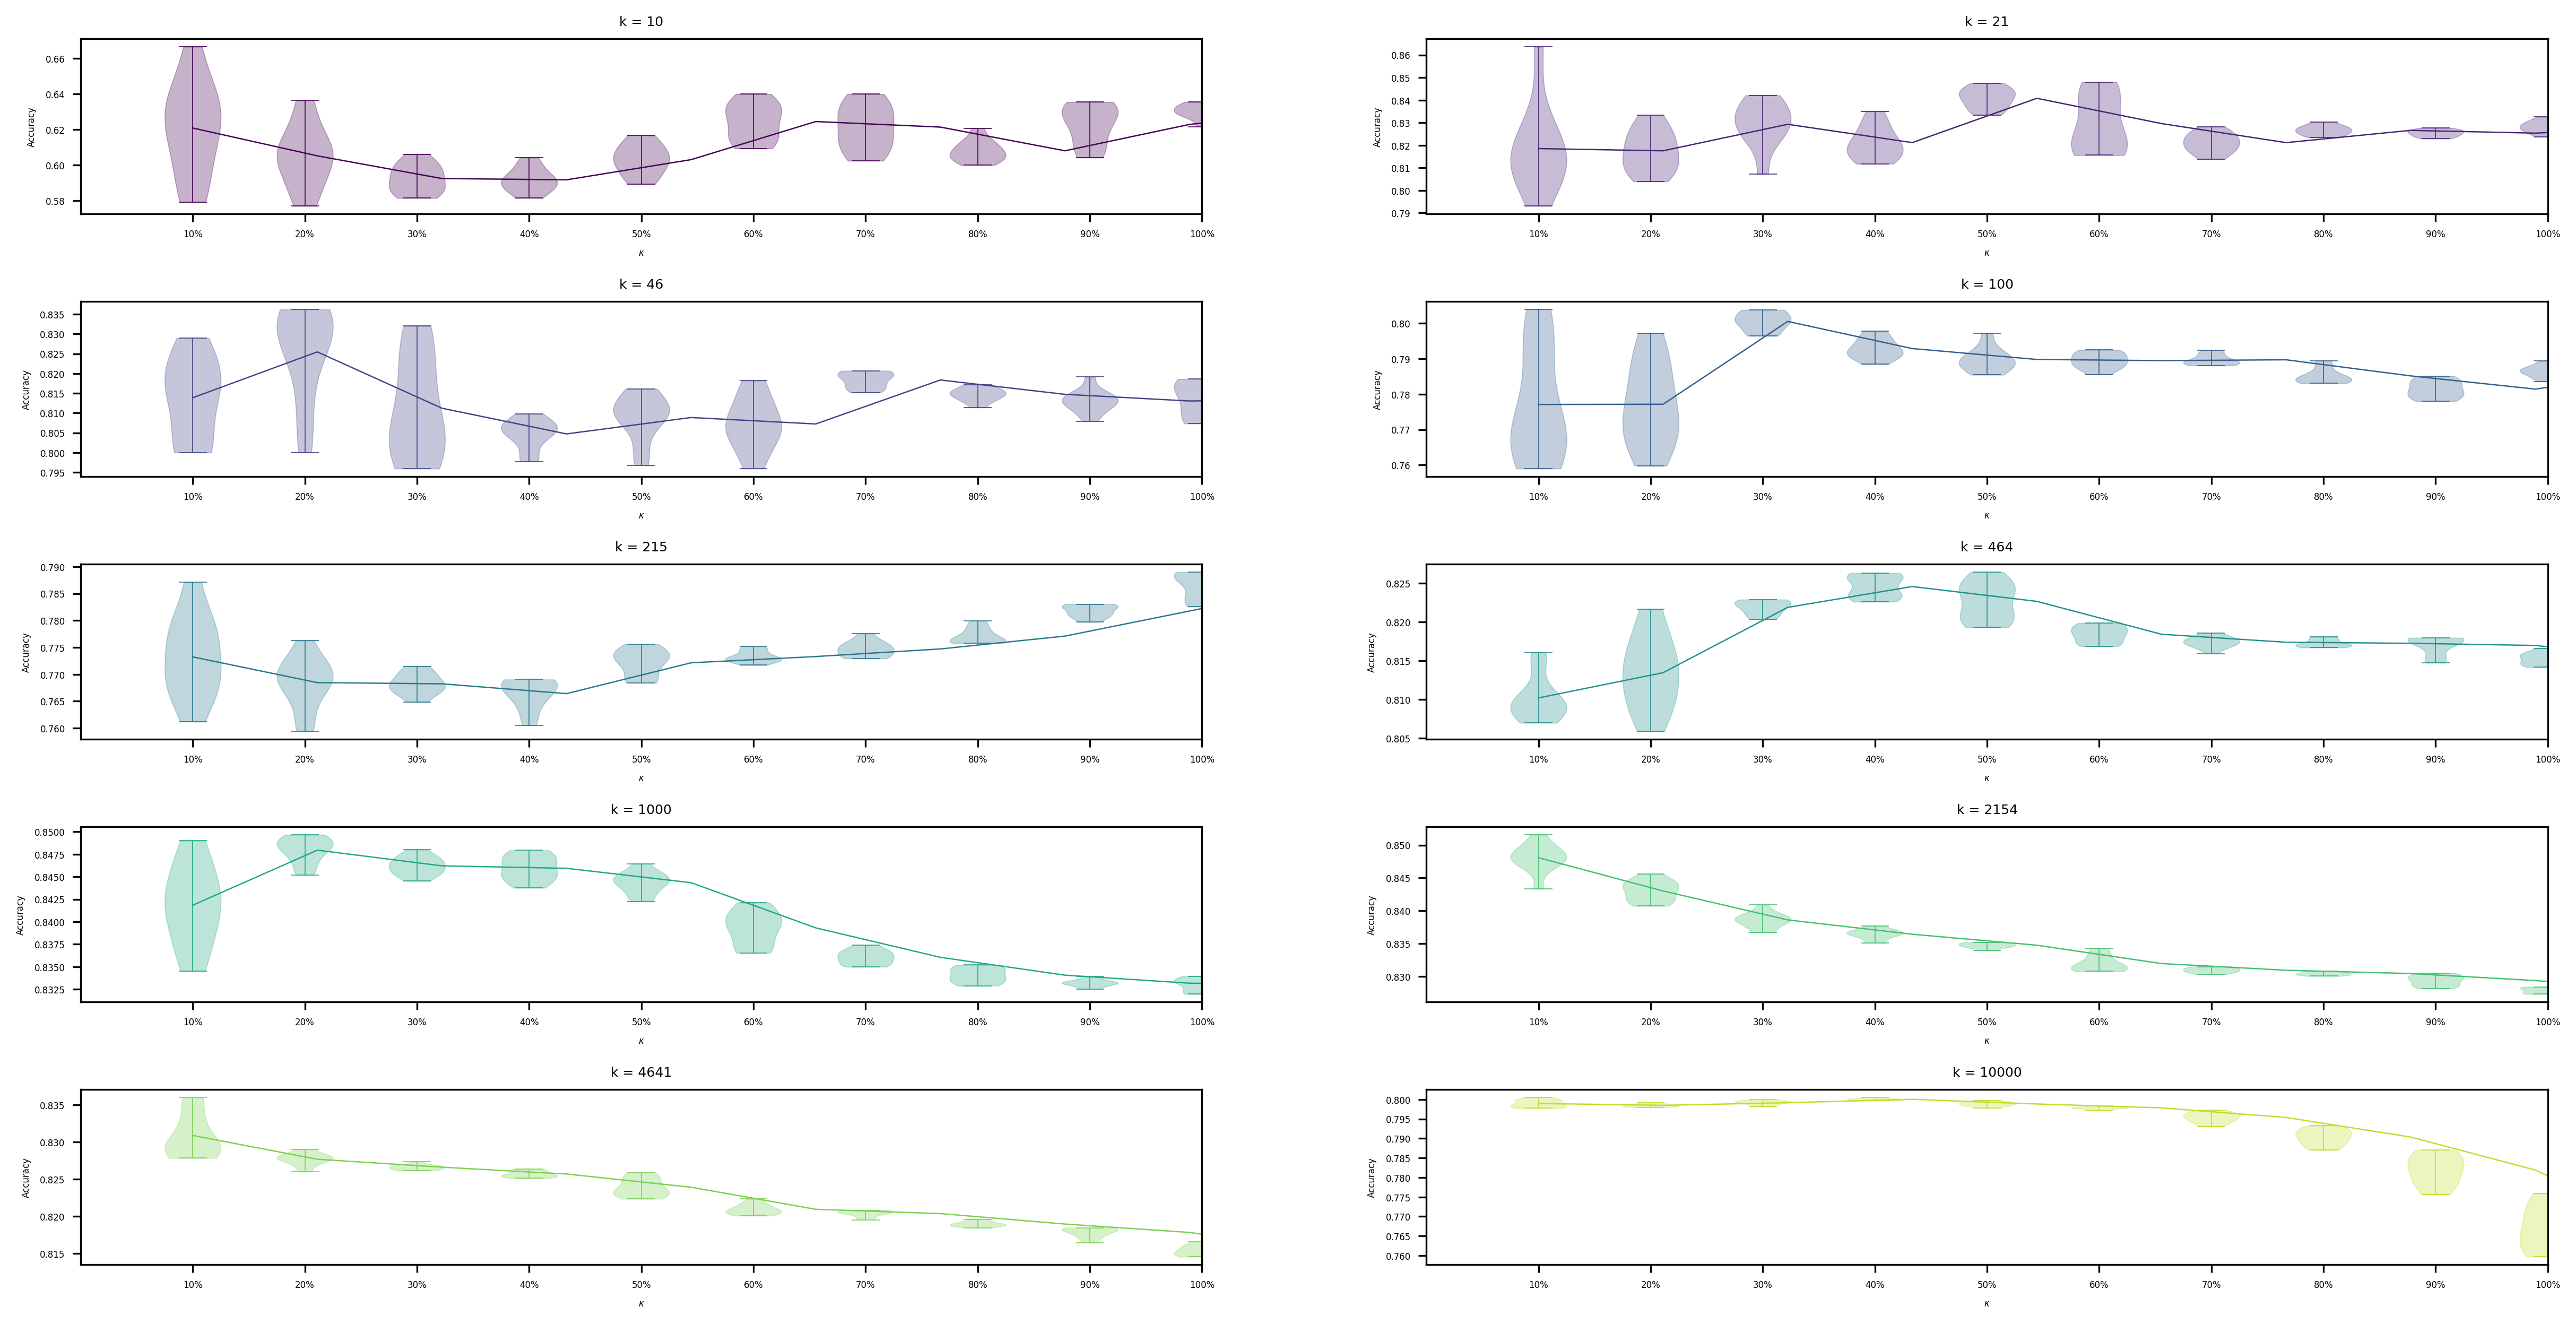

In [19]:
plt.figure(figsize=(20, 10), dpi=300)
plt.subplots_adjust(hspace=0.5, wspace=0.2)
colormap = plt.cm.viridis

# plt.suptitle("Accuracy vs. $\\kappa$ for different values of $k$")
axes = []
for i in range(5):
    for j in range(2):
        axes.append(plt.subplot2grid((5, 2), (i, j)))

for i, (k, accuracies, hamming_losses) in enumerate(zip(ks, all_accuracies, all_hamming_losses)):
    ax = axes[i]
    # Set font size of ax
    ax.tick_params(labelsize=4)
    ax.set_title("k = {}".format(k), fontsize=6)
    ax.set_xlabel("$\\kappa$", fontsize=4)
    ax.set_ylabel("Accuracy", fontsize=4)
    # ax.set_ylim(0.5, 1.05)
    ax.set_xlim(0, 1)

    violin = ax.violinplot(list(all_accuracies[i]))
    for j in range(len(violin["bodies"])):
        violin["bodies"][j].set_facecolor(colormap(i / len(ks)))
        violin["bodies"][j].set_edgecolor(colormap(i / len(ks)))
        violin["bodies"][j].set_linewidth(0.4)
    violin["cmaxes"].set_color(colormap(i / len(ks)))
    violin["cmins"].set_color(colormap(i / len(ks)))
    violin["cbars"].set_color(colormap(i / len(ks)))
    violin["cmaxes"].set_linewidth(0.4)
    violin["cmins"].set_linewidth(0.4)
    violin["cbars"].set_linewidth(0.4)
    ax.set_xticks(range(1, 11), map(lambda x: f"{int(x)}%", np.round(np.linspace(10, 100, 10), 1)))

    ax.plot(np.linspace(1, 11, 10), accuracies.mean(axis=1), color=colormap(i / len(ks)), linewidth=0.6)

plt.savefig("accuracy_vs_kappa_10k.png", dpi=300, transparent=True)

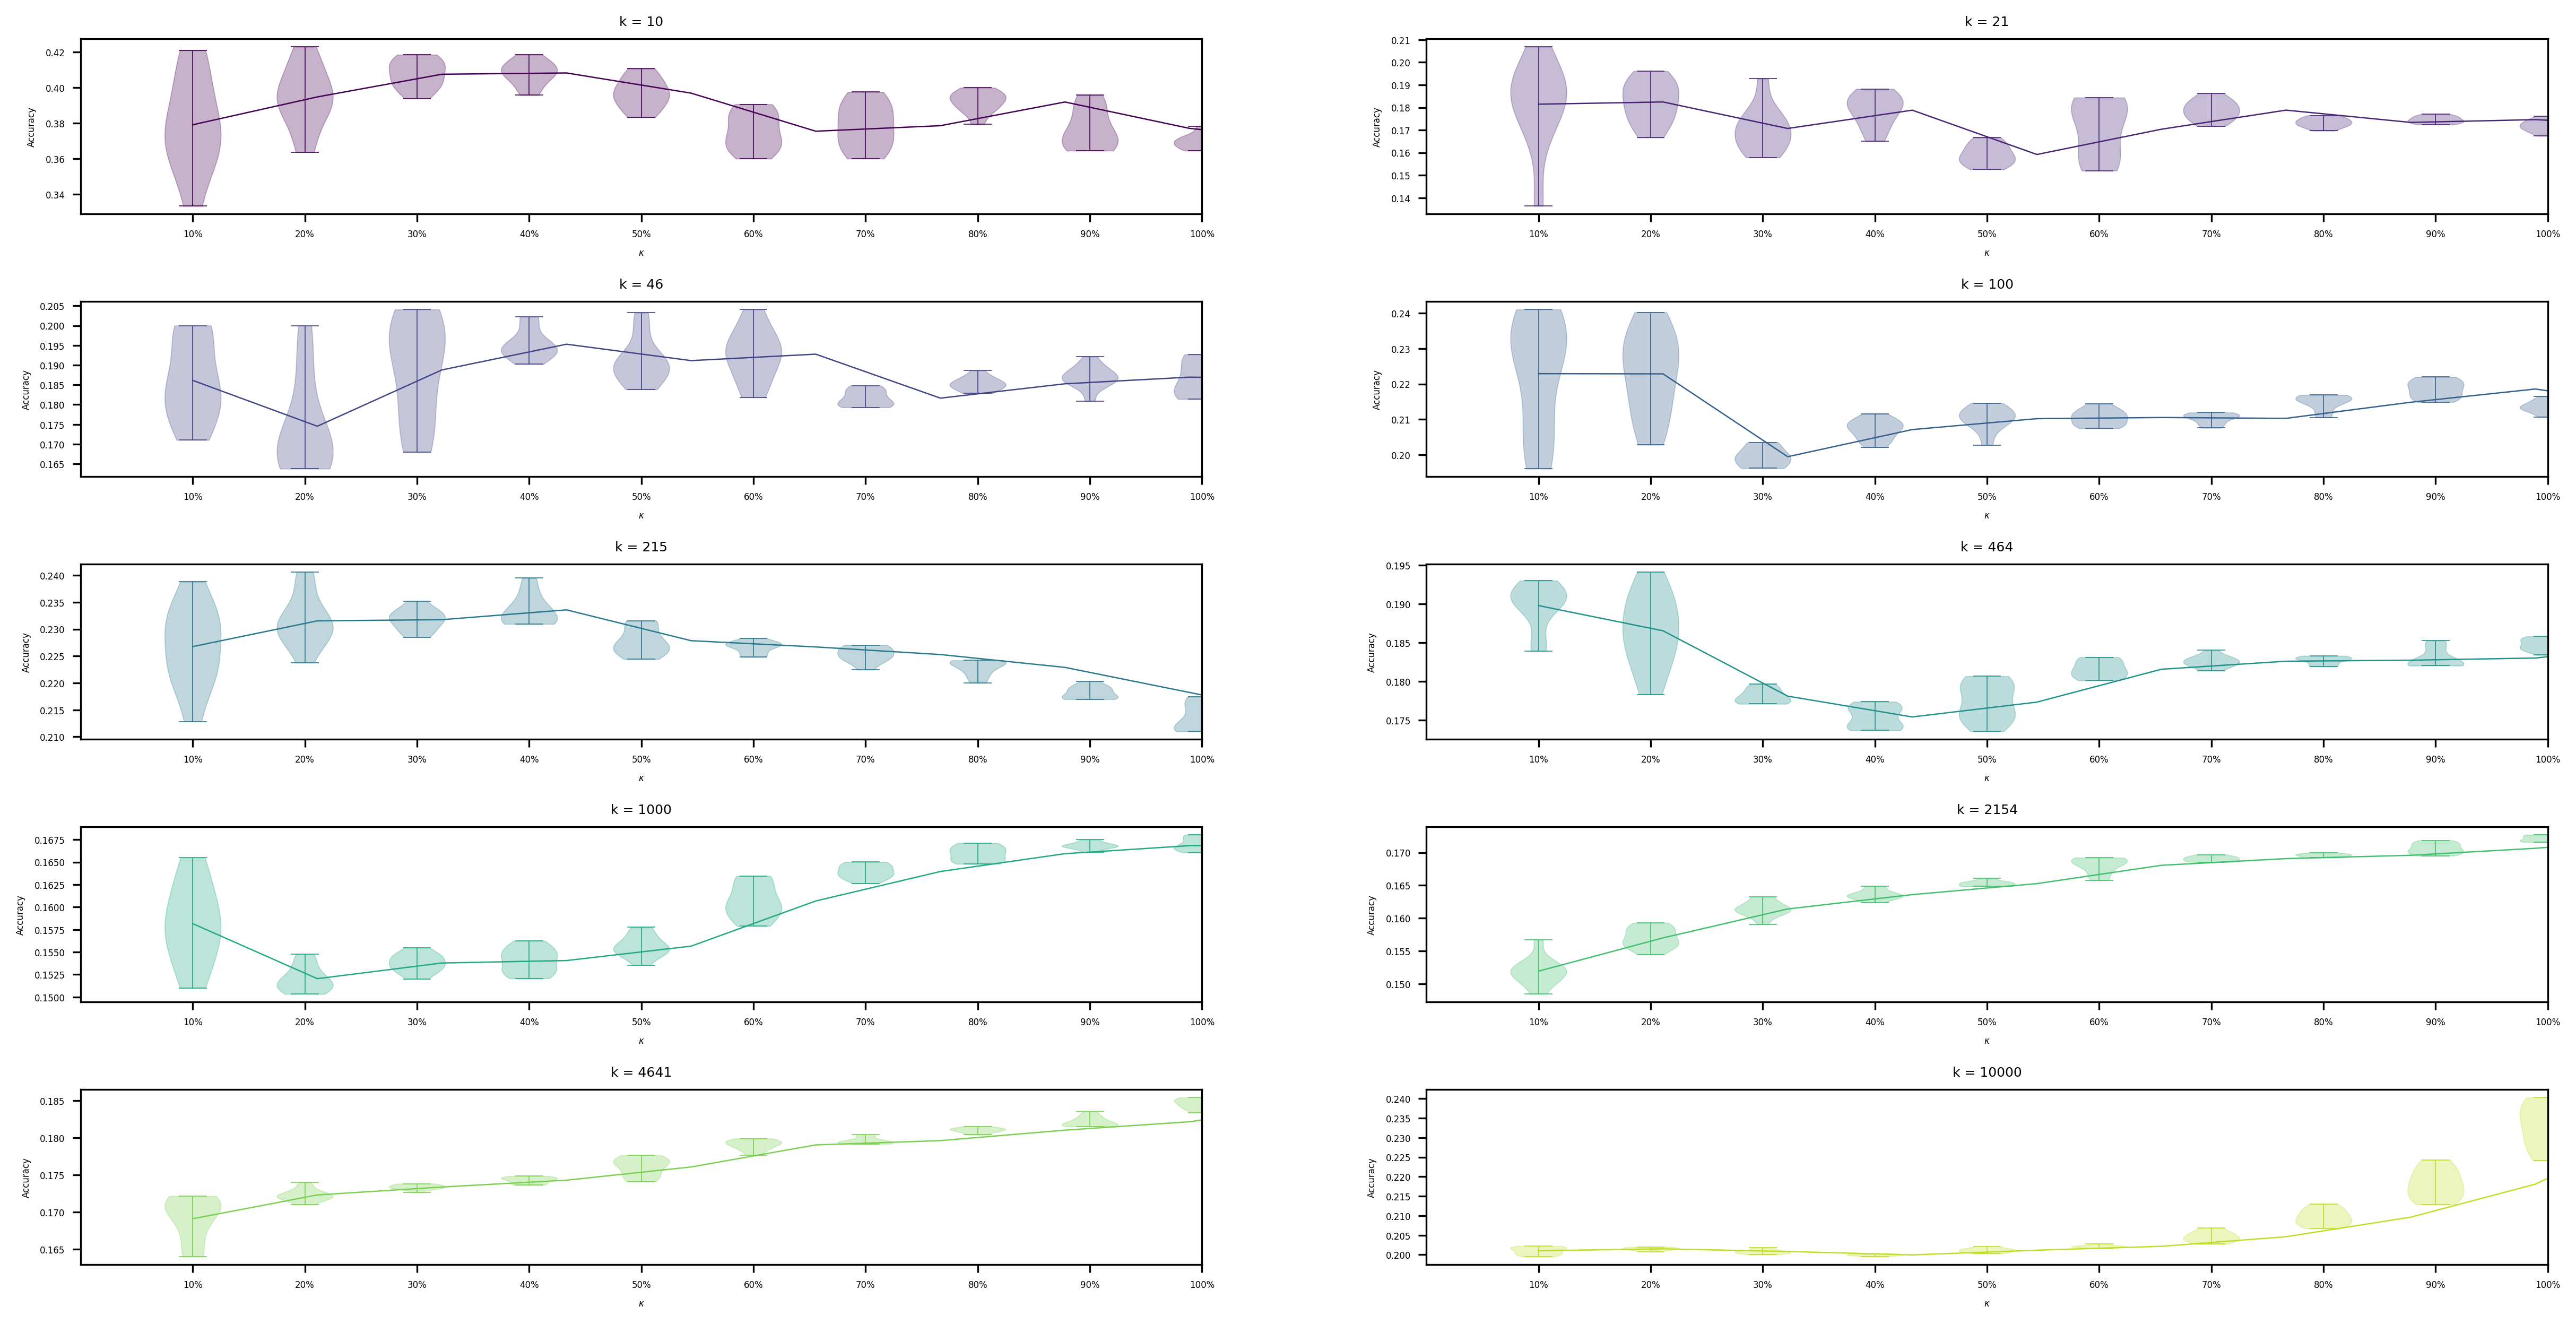

In [20]:
plt.figure(figsize=(20, 10), dpi=300)
plt.subplots_adjust(hspace=0.5, wspace=0.2)
colormap = plt.cm.viridis

axes = []
for i in range(5):
    for j in range(2):
        axes.append(plt.subplot2grid((5, 2), (i, j)))

for i, (k, accuracies, hamming_losses) in enumerate(zip(ks, all_accuracies, all_hamming_losses)):
    ax = axes[i]
    # Set font size of ax
    ax.tick_params(labelsize=4)
    ax.set_title("k = {}".format(k), fontsize=6)
    ax.set_xlabel("$\\kappa$", fontsize=4)
    ax.set_ylabel("Accuracy", fontsize=4)
    ax.set_xlim(0, 1)

    violin = ax.violinplot(list(all_hamming_losses[i]))
    for j in range(len(violin["bodies"])):
        violin["bodies"][j].set_facecolor(colormap(i / len(ks)))
        violin["bodies"][j].set_edgecolor(colormap(i / len(ks)))
        violin["bodies"][j].set_linewidth(0.4)
    violin["cmaxes"].set_color(colormap(i / len(ks)))
    violin["cmins"].set_color(colormap(i / len(ks)))
    violin["cbars"].set_color(colormap(i / len(ks)))
    violin["cmaxes"].set_linewidth(0.4)
    violin["cmins"].set_linewidth(0.4)
    violin["cbars"].set_linewidth(0.4)
    ax.set_xticks(range(1, 11), map(lambda x: f"{int(x)}%", np.round(np.linspace(10, 100, 10), 1)))

    ax.plot(np.linspace(1, 11, 10), hamming_losses.mean(axis=1), color=colormap(i / len(ks)), linewidth=0.6)

plt.savefig("hamming_vs_kappa_10k.png", dpi=300, transparent=True)


In [21]:
# import matplotlib.patches as mpatches

# plt.figure(figsize=(10, 10), dpi=300)
# colormap = plt.cm.viridis

# violins = []
# for i, k in enumerate(ks):
#     violin = plt.violinplot(list(all_accuracies[i]))
#     for j in range(len(violin["bodies"])):
#         violin["bodies"][j].set_facecolor(colormap(i / len(ks)))
#         violin["bodies"][j].set_edgecolor(colormap(i / len(ks)))
#         violin["bodies"][j].set_linewidth(0.4)
#     violin["cmaxes"].set_color(colormap(i / len(ks)))
#     violin["cmins"].set_color(colormap(i / len(ks)))
#     violin["cbars"].set_color(colormap(i / len(ks)))
#     violin["cmaxes"].set_linewidth(0.4)
#     violin["cmins"].set_linewidth(0.4)
#     violin["cbars"].set_linewidth(0.4)
#     violins.append(violin)

# plt.legend(handles=[
#     mpatches.Patch(color=violin["bodies"][0].get_facecolor(), label=f"k = {k}") for violin, k in zip(violins, ks)
# ], loc="lower left")
# plt.xticks(range(1, 11), map(lambda x: f"{int(x)}%", np.round(np.linspace(10, 100, 10), 1)))
# plt.xlabel("Percentage of most extreme test samples")
# plt.ylabel("Accuracy")
# plt.title("Accuracy vs. percentage of most extreme test samples")
# plt.show()

In [22]:
# import matplotlib.patches as mpatches

# plt.figure(figsize=(10, 10), dpi=300)
# colormap = plt.cm.viridis

# violins = []
# for i, k in enumerate(ks):
#     violin = plt.violinplot(list(all_hamming_losses[i]))
#     for j in range(len(violin["bodies"])):
#         violin["bodies"][j].set_facecolor(colormap(i / len(ks)))
#         violin["bodies"][j].set_edgecolor(colormap(i / len(ks)))
#         violin["bodies"][j].set_linewidth(0.4)
#     violin["cmaxes"].set_color(colormap(i / len(ks)))
#     violin["cmins"].set_color(colormap(i / len(ks)))
#     violin["cbars"].set_color(colormap(i / len(ks)))
#     violin["cmaxes"].set_linewidth(0.4)
#     violin["cmins"].set_linewidth(0.4)
#     violin["cbars"].set_linewidth(0.4)
#     violins.append(violin)

# plt.legend(handles=[
#     mpatches.Patch(color=violin["bodies"][0].get_facecolor(), label=f"k = {k}") for violin, k in zip(violins, ks)
# ], loc="lower right")
# plt.xticks(range(1, 11), map(lambda x: f"{int(x)}%", np.round(np.linspace(10, 100, 10), 1)))
# plt.xlabel("Percentage of most extreme test samples")
# plt.ylabel("Hamming Loss")
# plt.title("Hamming Loss vs percentage of most extreme test samples")
# plt.show()